In [1]:
import scipy.io as sio
import numpy as np
from scipy.linalg import toeplitz
from scipy.linalg import eigh
from copy import deepcopy
from scipy.optimize import minimize
from scipy.stats import truncnorm
from matplotlib import pyplot as plt
from scipy.special import erf
from mpl_toolkits.mplot3d import Axes3D
import cmath
import matplotlib
import tfim_1d
import quspin
import fejer_kernel
import fourier_filter
import generate_cdf
from qcels import *
matplotlib.rcParams['font.size'] = 15
matplotlib.rcParams['lines.markersize'] = 10

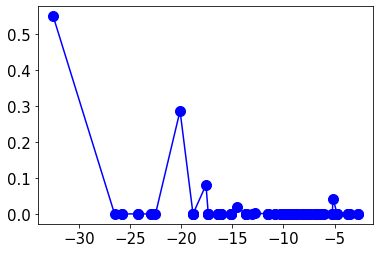

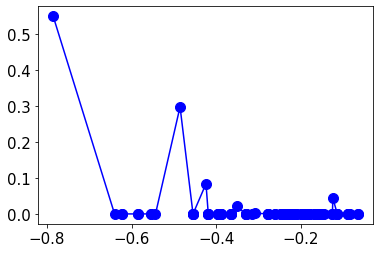

In [2]:
num_sites = 8
J = 1.0
g = 4.0

num_eigenstates_max = 100

ham0 = tfim_1d.generate_ham(num_sites, J, 1.0)
ground_state_0 = ham0.eigsh(k=1,which="SA")[1][:,0]

ham = tfim_1d.generate_ham(num_sites, J, g)
if( num_eigenstates_max > ham.shape[0] // 2):
    eigenenergies, eigenstates = ham.eigh()
else:
    eigenenergies, eigenstates = ham.eigsh(k=num_eigenstates_max,which="SA")
ground_state = eigenstates[:,0]

population_raw = np.abs(np.dot(eigenstates.conj().T, ground_state_0))**2

plt.plot(eigenenergies,population_raw,'b-o');plt.show()

spectrum, population = generate_spectrum_population(eigenenergies, population_raw, 
                                                    [population_raw[0]])

plt.plot(spectrum, population,'b-o');plt.show()


In [3]:
p0_array = np.array([0.4], dtype='float') #initial overlap with the first eigenvector
p1_array=np.array([0.4], dtype='float') #initial overlap with the second eigenvector
T_gap = 115
N_test_QCELS = 10  #number of different circuit depths for QCELS test
N_QPE = 10  #number of different circuit depths for QCELS QPE test
T_list_QCELS = T_gap*(2**(np.arange(N_test_QCELS)))### circuit depth for QCELS
T_list_QPE = T_gap*(2**(np.arange(N_QPE)))###circuit depth for QPE
err_QCELS_ground_gaussian=np.zeros((len(p0_array),len(T_list_QCELS)))
err_QCELS_gaussian=np.zeros((len(p0_array),len(T_list_QCELS)))
err_QPE=np.zeros((len(p0_array),len(T_list_QPE)))
cost_list_avg_QCELS_gaussian = np.zeros((len(p0_array),len(T_list_QCELS)))
cost_list_avg_QPE = np.zeros((len(p0_array),len(T_list_QPE)))
rate_success_QCELS_gaussian=np.zeros((len(p0_array),len(T_list_QCELS)))
rate_success_QPE=np.zeros((len(p0_array),len(T_list_QPE)))
max_T_QCELS_gaussian=np.zeros((len(p0_array),len(T_list_QCELS)))
Navg = 10 #number of trying
err_thres_hold=0.01
err_thres_hold_QPE=0.01
#-----------------------------    
for a1 in range(len(p0_array)):
    p0=p0_array[a1]
    p1=p1_array[a1]
    n_success_QCELS_gaussian= np.zeros(len(T_list_QCELS))
    n_success_QPE= np.zeros(len(T_list_QPE))
    for n_test in range(Navg):
        print("For p0,p1=",[p0,p1],"For N_test=",n_test+1)
        spectrum, population = generate_spectrum_population(eigenenergies, 
                population_raw, [p0,p1])
        spectrum=spectrum+np.random.uniform(-1,1)*0.05
        #------------------QCELS-Gaussian-----------------
        gamma=1
        K=2
        for ix in range(len(T_list_QCELS)):
            T = T_list_QCELS[ix]
            T_0 = 2/(spectrum[1]-spectrum[0])
            NT_0 = 3000
            NT = 2000
            lambda_prior = spectrum[0:2]+np.random.uniform(-1/2,1/2,2)/T_0
            ground_energy_estimate=np.zeros(len(lambda_prior))
            ground_energy_estimate_QCELS, cost_list_QCELS_this, max_T_QCELS_this = \
                    qcels_multimodal(spectrum, population, T_0, T, NT_0, NT, gamma, K, lambda_prior)#QCELS with time T
            for n in range(len(lambda_prior)):
                 ground_energy_estimate[n]=ground_energy_estimate_QCELS[3*n+3-1]
            err_this_run_QCELS_ground = np.abs(ground_energy_estimate[0] - spectrum[0])
            err_this_run_QCELS = np.linalg.norm(ground_energy_estimate - spectrum[0:2])
            err_QCELS_ground_gaussian[a1,ix] = err_QCELS_ground_gaussian[a1,ix]+np.abs(err_this_run_QCELS_ground)
            err_QCELS_gaussian[a1,ix] = err_QCELS_gaussian[a1,ix]+np.abs(err_this_run_QCELS)
            cost_list_avg_QCELS_gaussian[a1,ix]=cost_list_avg_QCELS_gaussian[a1,ix]+cost_list_QCELS_this
            max_T_QCELS_gaussian[a1,ix]=max(max_T_QCELS_gaussian[a1,ix],max_T_QCELS_this)
            if np.abs(err_this_run_QCELS)<err_thres_hold:
                n_success_QCELS_gaussian[ix]+=1
            else:
                print('TGF fail')
#        # ----------------- QPE -----------------------
        N_try_QPE=int(15*np.ceil(1.0/p0)) #number of QPE samples each time
        for ix in range(len(T_list_QPE)):
            T = int(T_list_QPE[ix])
            discrete_energies = 2*np.pi*np.arange(2*T)/(2*T) - np.pi 
            dist = generate_QPE_distribution(spectrum,population,2*T) #Generate QPE samples
            samp = generate_cdf.draw_with_prob(dist,N_try_QPE)
            j_min = samp.min()
            ground_energy_estimate_QPE = discrete_energies[j_min]
            err_this_run_QPE = np.abs(ground_energy_estimate_QPE-spectrum[0])
            err_QPE[a1,ix] = err_QPE[a1,ix]+np.abs(err_this_run_QPE)
            if np.abs(err_this_run_QPE)<err_thres_hold_QPE:
                n_success_QPE[ix]+=1
            cost_list_avg_QPE[a1,ix] = T*N_try_QPE
#     rate_success_QCELS[a1,:] = n_success_QCELS[:]/Navg
#     err_QCELS[a1,:] = err_QCELS[a1,:]/Navg
#     err_QCELS_ground[a1,:] = err_QCELS_ground[a1,:]/Navg
    rate_success_QCELS_gaussian[a1,:] = n_success_QCELS_gaussian[:]/Navg
    err_QCELS_gaussian[a1,:] = err_QCELS_gaussian[a1,:]/Navg
    err_QCELS_ground_gaussian[a1,:] = err_QCELS_ground_gaussian[a1,:]/Navg
    rate_success_QPE[a1,:] = n_success_QPE[:]/Navg
    err_QPE[a1,:] = err_QPE[a1,:]/Navg
#     cost_list_avg_QCELS[a1,:]=cost_list_avg_QCELS[a1,:]/Navg
    cost_list_avg_QCELS_gaussian[a1,:]=cost_list_avg_QCELS_gaussian[a1,:]/Navg

For p0,p1= [0.4, 0.4] For N_test= 1
For p0,p1= [0.4, 0.4] For N_test= 2
For p0,p1= [0.4, 0.4] For N_test= 3
For p0,p1= [0.4, 0.4] For N_test= 4
For p0,p1= [0.4, 0.4] For N_test= 5
For p0,p1= [0.4, 0.4] For N_test= 6
For p0,p1= [0.4, 0.4] For N_test= 7
For p0,p1= [0.4, 0.4] For N_test= 8
For p0,p1= [0.4, 0.4] For N_test= 9
For p0,p1= [0.4, 0.4] For N_test= 10


[[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]]
[[0.1 0.1 0.4 0.6 1.  0.8 1.  1.  1.  1. ]]


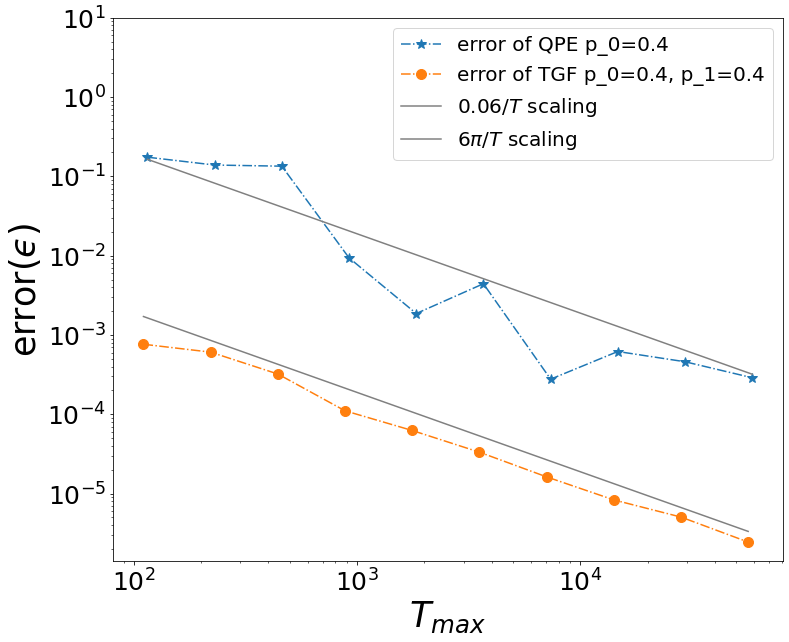

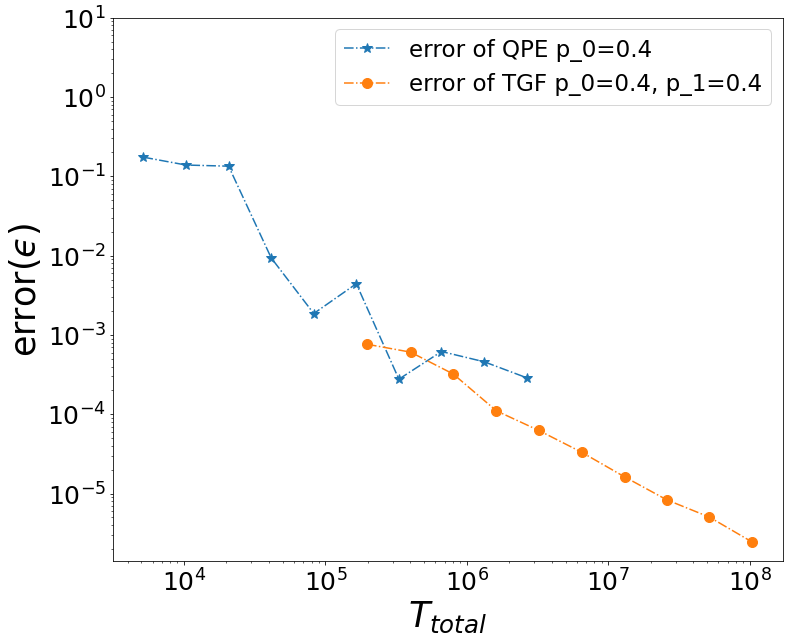

In [4]:
print(rate_success_QCELS_gaussian)
print(rate_success_QPE)
fig1=plt.figure(figsize=(12,10))
plt.plot(T_list_QPE,err_QPE[0,:],linestyle="-.",marker="*",
         label="error of QPE p_0={}".format(p0_array[0]))
plt.plot(max_T_QCELS_gaussian[0,:],err_QCELS_gaussian[0,:],linestyle="-.",marker="o",
         label="error of TGF p_0={}, p_1={}".format(p0_array[0],p1_array[0]))
plt.plot(max_T_QCELS_gaussian[0,:],0.06*np.pi/max_T_QCELS_gaussian[0,:],linestyle="-",color="grey",label="$0.06/T$ scaling")
plt.plot(T_list_QPE,6*np.pi/T_list_QPE,linestyle="-",color="grey",label="$6\pi/T$ scaling")
plt.xlabel("$T_{max}$",fontsize=35)
plt.ylabel("error($ϵ$)",fontsize=35)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.xscale("log")
plt.yscale("log")
plt.ylim(top=10)
plt.legend(fontsize=20)
plt.savefig('TFIM_depth_8_all.pdf')
fig2=plt.figure(figsize=(12,10))
plt.plot(cost_list_avg_QPE[0,:],err_QPE[0,:],linestyle="-.",marker="*",
         label="error of QPE p_0={}".format(p0_array[0]))
plt.plot(cost_list_avg_QCELS_gaussian[0,:],err_QCELS_gaussian[0,:],linestyle="-.",marker="o",
         label="error of TGF p_0={}, p_1={}".format(p0_array[0],p1_array[0]))
plt.xlabel("$T_{total}$",fontsize=35)
plt.ylabel("error($ϵ$)",fontsize=35) 
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.xscale("log")
plt.yscale("log")
plt.ylim(top=10)
plt.legend(fontsize=23)
plt.savefig('TFIM_cost_8_all.pdf')
plt.show()

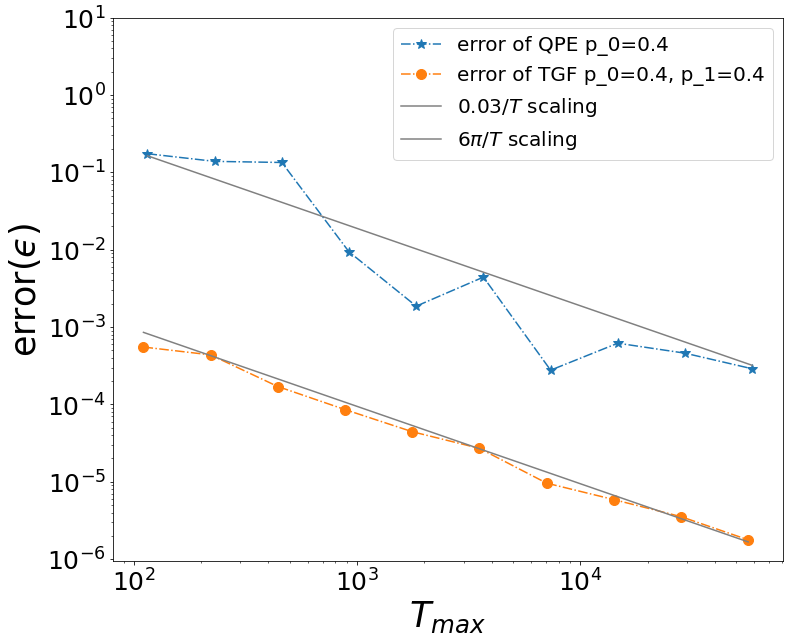

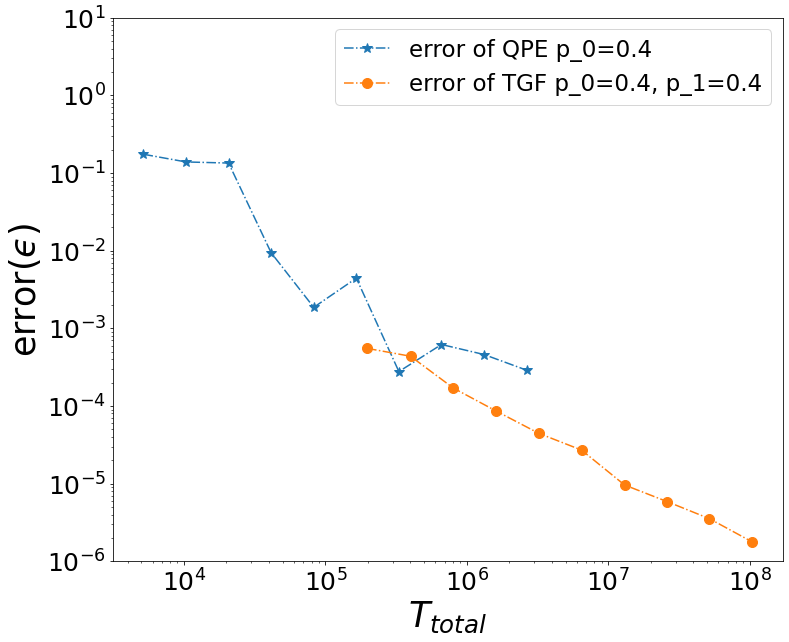

In [5]:
fig3=plt.figure(figsize=(12,10))
plt.plot(T_list_QPE,err_QPE[0,:],linestyle="-.",marker="*",
         label="error of QPE p_0={}".format(p0_array[0]))
plt.plot(max_T_QCELS_gaussian[0,:],err_QCELS_ground_gaussian[0,:],linestyle="-.",marker="o",
         label="error of TGF p_0={}, p_1={}".format(p0_array[0],p1_array[0]))
plt.plot(max_T_QCELS_gaussian[0,:],0.03*np.pi/max_T_QCELS_gaussian[0,:],linestyle="-",color="grey",label="$0.03/T$ scaling")
plt.plot(T_list_QPE,6*np.pi/T_list_QPE,linestyle="-",color="grey",label="$6\pi/T$ scaling")
plt.xlabel("$T_{max}$",fontsize=35)
plt.ylabel("error($ϵ$)",fontsize=35)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.xscale("log")
plt.yscale("log")
plt.ylim(top=10)
plt.legend(fontsize=20)
plt.savefig('TFIM_depth_8_ground.pdf')
fig4=plt.figure(figsize=(12,10))
plt.plot(cost_list_avg_QPE[0,:],err_QPE[0,:],linestyle="-.",marker="*",
         label="error of QPE p_0={}".format(p0_array[0]))
plt.plot(cost_list_avg_QCELS_gaussian[0,:],err_QCELS_ground_gaussian[0,:],linestyle="-.",marker="o",
         label="error of TGF p_0={}, p_1={}".format(p0_array[0],p1_array[0]))
plt.xlabel("$T_{total}$",fontsize=35)
plt.ylabel("error($ϵ$)",fontsize=35) 
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.xscale("log")
plt.yscale("log")
plt.ylim(top=10)
plt.legend(fontsize=23)
plt.savefig('TFIM_cost_8_ground.pdf')
plt.show()

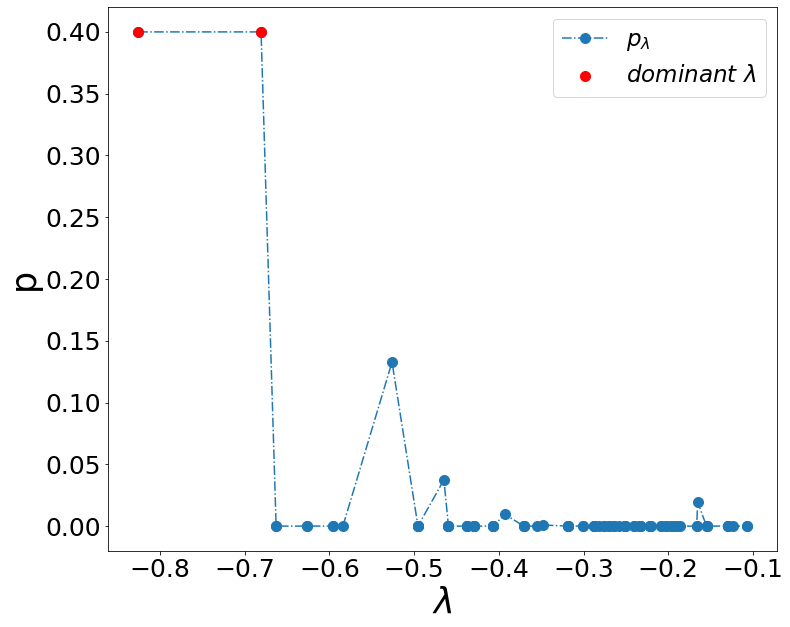

In [6]:
fig5=plt.figure(figsize=(12,10))
plt.plot(spectrum,population,linestyle="-.",marker="o",
         label="$p_{\lambda}$",zorder = 1)
plt.xlabel("$\lambda$",fontsize=35)
plt.ylabel("p",fontsize=35) 
plt.scatter([spectrum[0],spectrum[1]],
            [population[0],population[1]],label=r"$dominant\ \lambda$",c ="red",zorder = 2)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.legend(fontsize=23)
plt.savefig('TFIM_eigendistribution.pdf')
plt.show()

# Minimal point evolution

In [30]:
T_list=np.linspace(40, 100, num=7)
T_list=np.append(T_list,np.linspace(200, 500, num=4))
Navg=100
NT_0 = 3000
NT = 2000
min_x=np.zeros([len(T_list),Navg])
x_test=np.linspace(-0.85, -0.75, num=500)
x_test=np.append(x_test,[spectrum[0]])
x_test=np.sort(x_test)
fun_x=np.zeros([len(x_test),len(T_list)])
for n_list in range(len(T_list)):
    T=T_list[n_list]
    print('T=',T)
    T_0=10
    N_level=int(np.log2(T/T_0))
    for k in range(Navg):
        Z_est=np.zeros(NT,dtype = 'complex_')
        x0=np.zeros(3*K,dtype = 'float')
        lambda_prior = spectrum[0:2]
        Z_est, ts, _, _=generate_Z_est_multimodal(
            spectrum,population,T_0,NT_0,gamma) #Approximate <\psi|\exp(-itH)|\psi> using Hadmard test
        #Step up and solve the optimization problem
        for n in range(K):
           x0[3*n:3*n+3]=np.array((np.random.uniform(0,1),0,lambda_prior[n]))
        #print(x0)
        #x0 = qcels_opt_coordinate_wise(ts, Z_est, x0)
        x0 = qcels_opt_coeff_first(ts, Z_est, x0)
        #print(x0)
        res = qcels_opt_multimodal(ts, Z_est, x0)#Solve the optimization problem
        #Update initial guess for next iteration
        x0=np.array(res.x)
        #print(x0)
        #Update the estimation interval
        bnds=np.zeros(6*K,dtype = 'float')
        for n in range(K):
           bnds[6*n]=-1
           bnds[6*n+1]=1
           bnds[6*n+2]=-1
           bnds[6*n+3]=1
           bnds[6*n+4]=x0[3*n+2]-np.pi/T_0
           bnds[6*n+5]=x0[3*n+2]+np.pi/T_0
        bnds= [(bnds[i], bnds[i+1]) for i in range(0, len(bnds), 2)]
    #    Iteration
        for n_QCELS in range(N_level):
            T=T_0*2**(n_QCELS+1)
            Z_est, ts, _, _=generate_Z_est_multimodal(
                spectrum,population,T,NT,gamma) #Approximate <\psi|\exp(-itH)|\psi> using Hadmard test
            #Step up and solve the optimization problem
            res = qcels_opt_multimodal(ts, Z_est, x0, bounds=bnds)#Solve the optimization problem
            #Update initial guess for next iteration
            x0=np.array(res.x)
            #Update the estimation interval
            bnds=np.zeros(6*K,dtype = 'float')
            for n in range(K):
               bnds[6*n]=-1
               bnds[6*n+1]=1
               bnds[6*n+2]=-1
               bnds[6*n+3]=1
               bnds[6*n+4]=x0[3*n+2]-np.pi/T
               bnds[6*n+5]=x0[3*n+2]+np.pi/T
            bnds= [(bnds[i], bnds[i+1]) for i in range(0, len(bnds), 2)]
            min_x[n_list,k]=min(x0[2],x0[5])
            if k==(Navg-1):
                if n_QCELS==(N_level-1):
                    for k_x in range(len(x_test)):
                        x1=list(x0)
                        x1[2]=x_test[k_x]
                        x1[5]=max(x0[2],x0[5])
                        fun_x[k_x,n_list]=qcels_opt_fun(x1, ts, Z_est)

T= 40.0
T= 50.0
T= 60.0
T= 70.0
T= 80.0
T= 90.0
T= 100.0
T= 200.0
T= 300.0
T= 400.0
T= 500.0


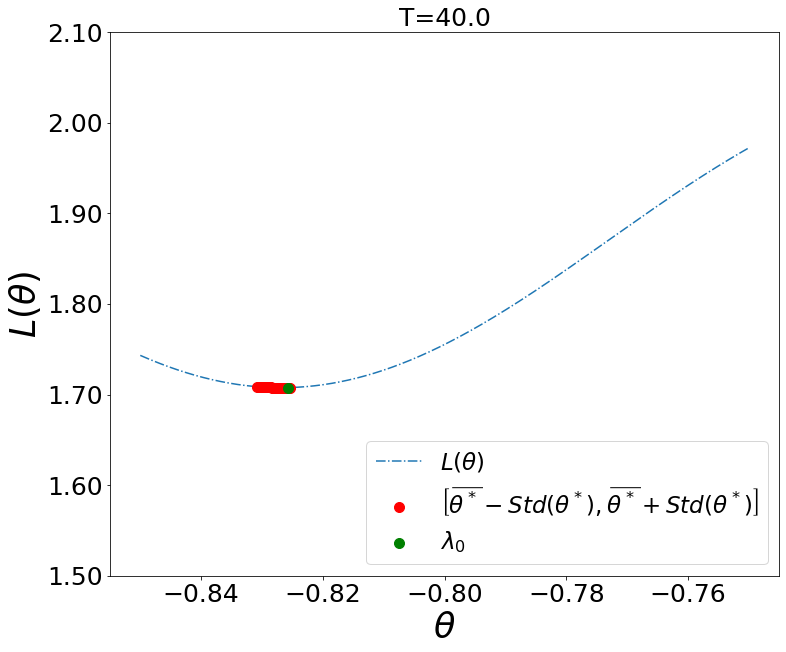

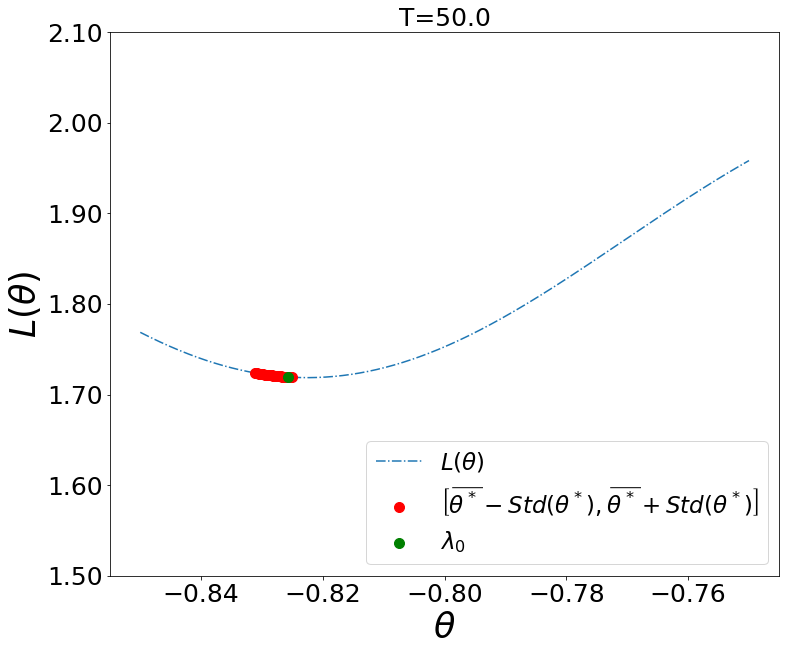

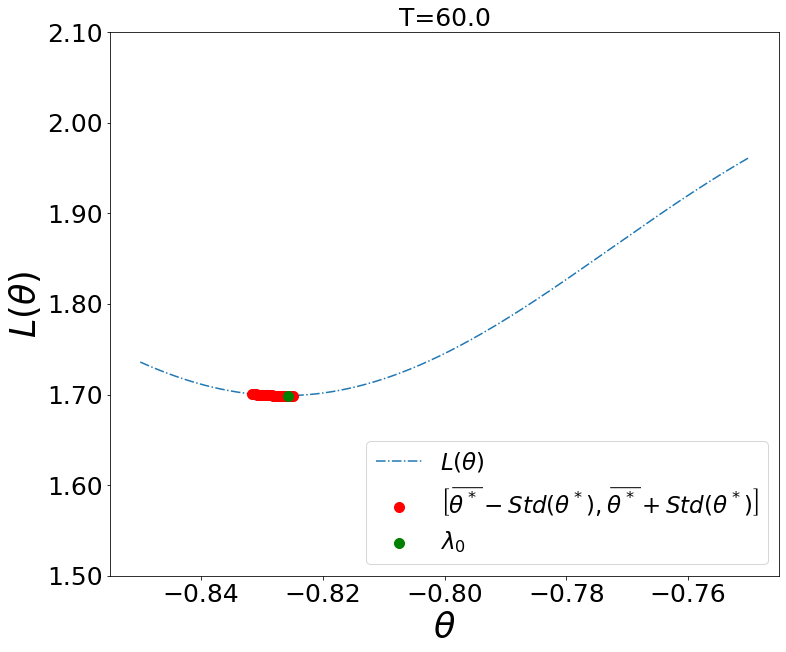

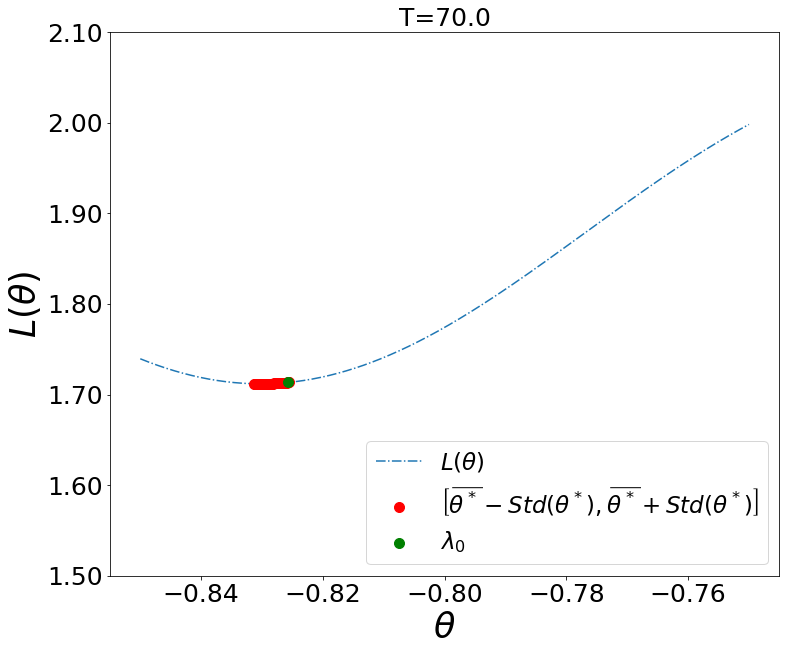

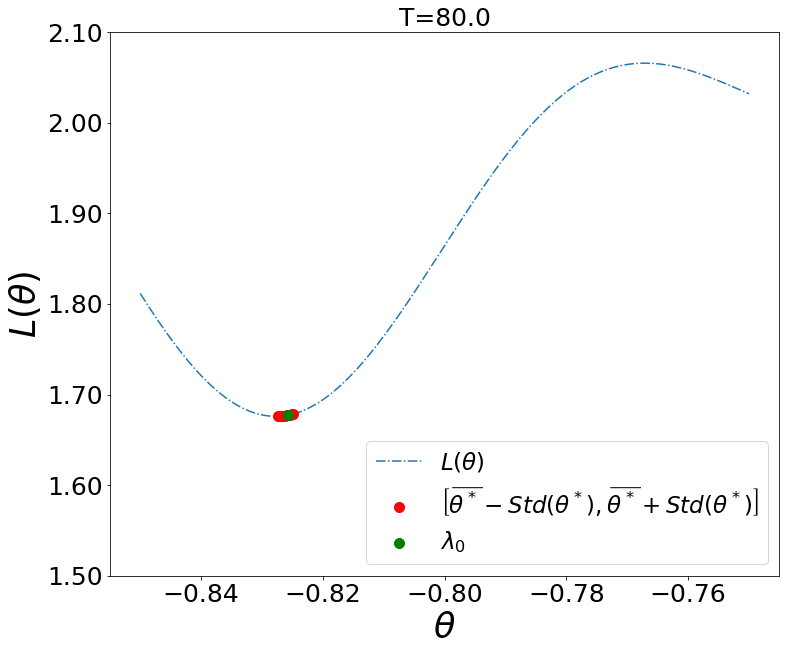

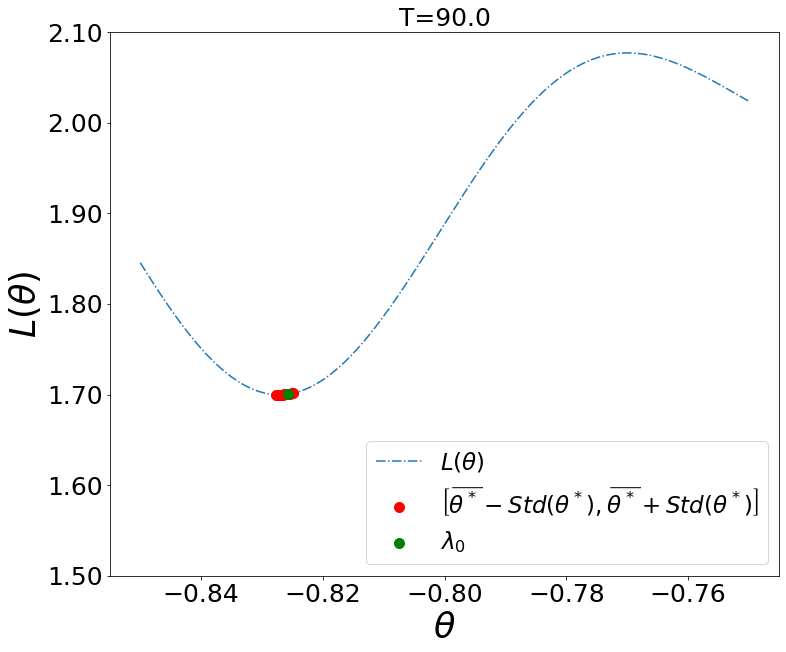

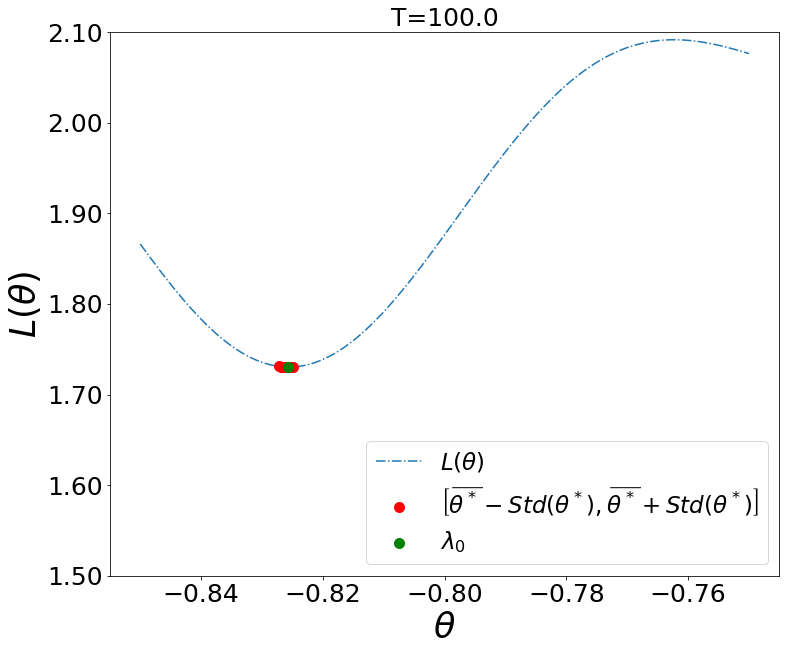

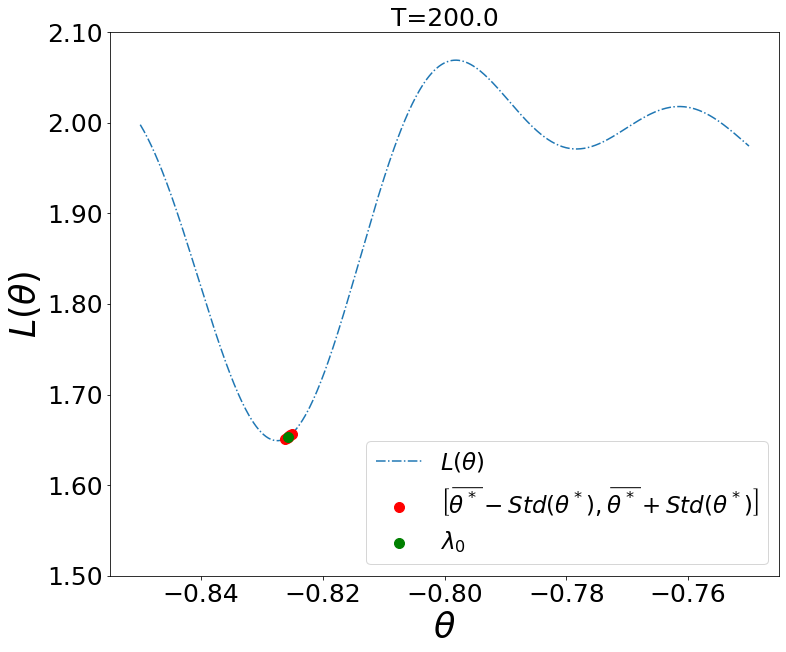

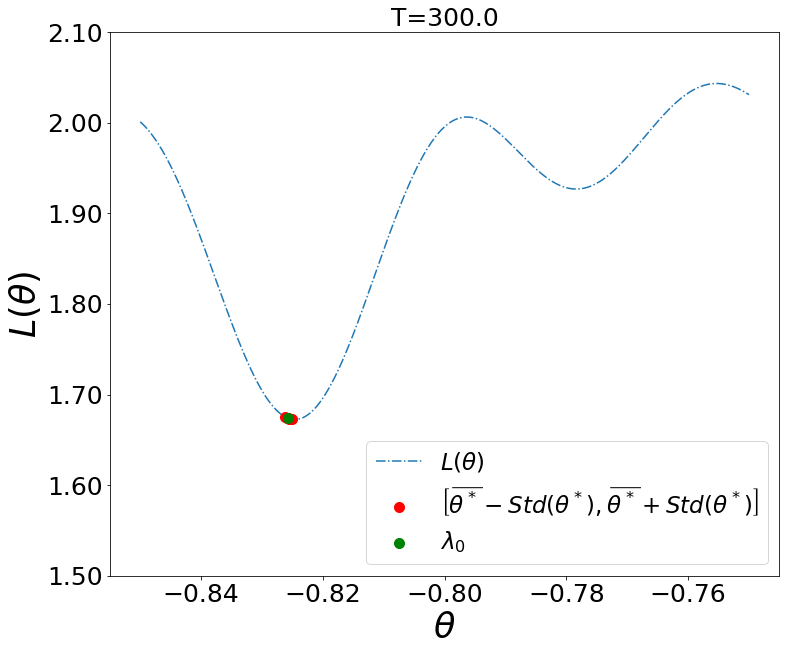

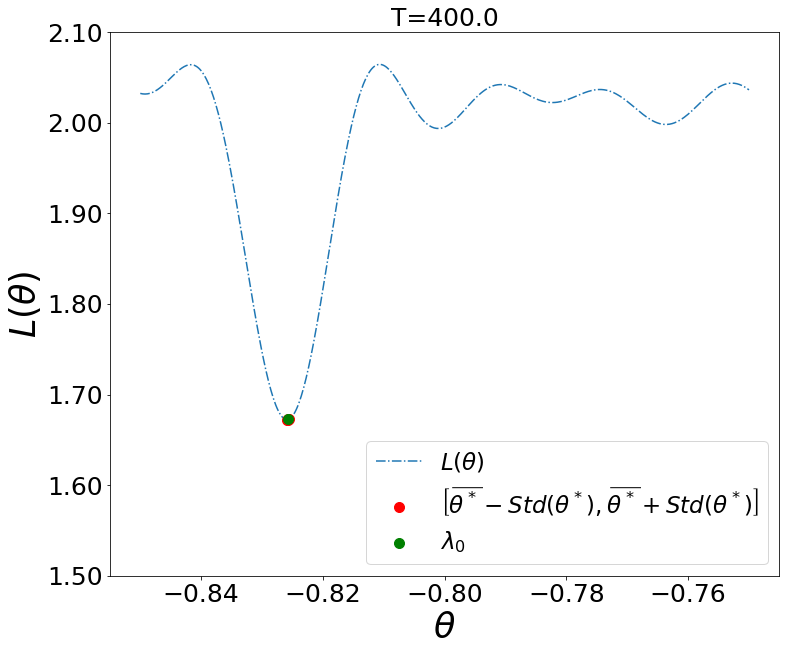

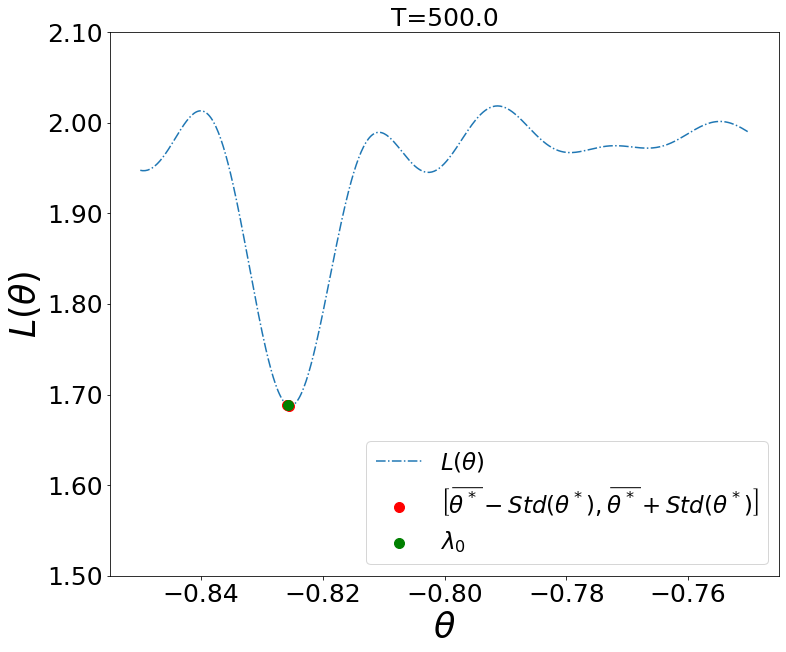

In [37]:
import matplotlib.ticker as mtick
import statistics 
for p in range(len(T_list)):
    fig=plt.figure(figsize=(12,10))
    ax = fig.add_subplot(111)
    plt.plot(x_test,fun_x[:,p],linestyle="-.",
             label=r"$L(\theta)$",zorder = 1)
    plt.xlabel(r"$\theta$",fontsize=35)
    plt.ylabel(r"$L(\theta)$",fontsize=35) 
    mean=statistics.mean(min_x[p,:])
    std=statistics.stdev(min_x[p,:])
#     theta_large=max(min_x[p,:])
#     theta_small=min(min_x[p,:])
    theta_large=mean+std
    theta_small=mean-std
    plt.scatter(x_test[np.where((x_test<theta_large)&(x_test>theta_small))],
                fun_x[np.where((x_test<theta_large)&(x_test>theta_small)),p]
                ,label=r"$\left[\widebar{\theta^*}-Std(\theta^*),\widebar{\theta^*}+Std(\theta^*)\right]$",c ="red",zorder = 2)
    plt.scatter(x_test[np.where((x_test==spectrum[0]))],
                fun_x[np.where((x_test==spectrum[0])),p]
                ,label=r"$\lambda_0$",c ="green",zorder = 2)
    plt.ylim(top=2.1)  
    plt.ylim(bottom=1.5) 
    plt.title('T='+str(T_list[p]),fontsize=25)
    ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.2f'))
    plt.xticks(fontsize=25)
    plt.yticks(fontsize=25)
    plt.legend(fontsize=23,loc=4)
    plt.savefig('TFIM_loss_function with T='+str(T_list[p])+'.pdf',facecolor='w')